<span style='color:green'> This notebook is almost entirely a starter notebook given by Kaggle in order to get contestants on their way. I have adjusted a few things in order to accommodate my file structure as well as added some notes here or there but it is mainly their work/file.</span>

# Overview

Welcome to the 2018 RSNA Challenge co-hosted by Kaggle. In this competition, the primary endpoint will be the detection of bounding boxes corresponding to the diagnosis of pneumonia (e.g. lung infection) on chest radiographs, a special 2D high resolution grayscale medical image. Note that pnuemonia is just one of many possible disease processes that can occur on a chest radiograph, and that any given single image may contain 0, 1 or many boxes corresponding to possible pneumonia locations.

My name is Peter Chang, MD. I am both a radiologist physician and a data scientist / software engineer with machine learning experience. Today, in this Jupyter notebook, we will explore the 2018 RSNA Challenge dataset including underlying data structures, imaging file formats and label types.

In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

# Challenge Data

The challenge data is organized in several files and folders. If you are following along in the Kaggle kernel, this data will be preloaded in the `../input` directory:

In [2]:
!ls ./data

GCP Credits Request Link - RSNA.txt stage_1_test_images.zip
all.zip                             stage_1_train_images
logs                                stage_1_train_images.zip
stage_1_detailed_class_info.csv     stage_1_train_labels.csv
stage_1_sample_submission.csv       submissions
stage_1_test_images


The several key items in this folder:
* `stage_1_train_labels.csv`: CSV file containing training set patientIds and  labels (including bounding boxes)
* `stage_1_detailed_class_info.csv`: CSV file containing detailed labels (explored further below)
* `stage_1_train_images/`:  directory containing training set raw image (DICOM) files

Let's go ahead and take a look at the first labels CSV file first:

In [3]:
df = pd.read_csv('./data/stage_1_train_labels.csv')
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


As you can see, each row in the CSV file contains a `patientId` (one unique value per patient), a target (either 0 or 1 for absence or presence of pneumonia, respectively) and the corresponding abnormality bounding box defined by the upper-left hand corner (x, y) coordinate and its corresponding width and height. In this particular case, the patient does *not* have pneumonia and so the corresponding bounding box information is set to `NaN`. See an example case with pnuemonia here:

In [4]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


One important thing to keep in mind is that a given `patientId` may have **multiple** boxes if more than one area of pneumonia is detected (see below for example images).

# Overview of DICOM files and medical images

Medical images are stored in a special format known as DICOM files (`*.dcm`). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. In Python, one popular library to access and manipulate DICOM files is the `pydicom` module. To use the `pydicom` library, first find the DICOM file for a given `patientId` by simply looking for the matching file in the `stage_1_train_images/` folder, and the use the `pydicom.read_file()` method to load the data:

In [5]:
patientId = df['patientId'][0]
dcm_file = './data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

Most of the standard headers containing patient identifable information have been anonymized (removed) so we are left with a relatively sparse set of metadata. The primary field we will be accessing is the underlying pixel data as follows:

In [6]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


## Considerations

As we can see here, the pixel array data is stored as a Numpy array, a powerful numeric Python library for handling and manipulating matrix data (among other things). In addition, it is apparent here that the original radiographs have been preprocessed for us as follows:

* The relatively high dynamic range, high bit-depth original images have been rescaled to 8-bit encoding (256 grayscales). For the radiologists out there, this means that the images have been windowed and leveled already. In clinical practice, manipulating the image bit-depth is typically done manually by a radiologist to highlight certain disease processes. To visually assess the quality of the automated bit-depth downscaling and for considerations on potentially improving this baseline, consider consultation with a radiologist physician.

* The relativley large original image matrices (typically acquired at >2000 x 2000) have been resized to the data-science friendly shape of 1024 x 1024. For the purposes of this challenge, the diagnosis of most pneumonia cases can typically be made at this resolution. To visually assess the feasibility of diagnosis at this resolution, and to determine the optimal resolution for pneumonia detection (oftentimes can be done at a resolution *even smaller* than 1024 x 1024), consider consultation with a radiogist physician.

## Visualizing An Example

To take a look at this first DICOM image, let's use the `pylab.imshow()` method:

(-0.5, 1023.5, 1023.5, -0.5)

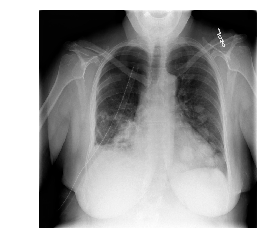

In [7]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

# Exploring the Data and Labels

As alluded to above, any given patient may potentially have many boxes if there are several different suspicious areas of pneumonia. To collapse the current CSV file dataframe into a dictionary with unique entries, consider the following method:

In [8]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': './data/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

Let's use the method here:

In [9]:
parsed = parse_data(df)

As we saw above, patient `00436515-870c-4b36-a041-de91049b9ab4` has pnuemonia so lets check our new `parsed` dict here to see the patients corresponding bounding boxes:

In [10]:
display(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': './data/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'label': 1,
 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}

# Visualizing Boxes

In order to overlay color boxes on the original grayscale DICOM files, consider using the following  methods (below, the main method `draw()` requires the method `overlay_box()`):

In [11]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

As we saw above, patient `00436515-870c-4b36-a041-de91049b9ab4` has pnuemonia so let's take a look at the overlaid bounding boxes:

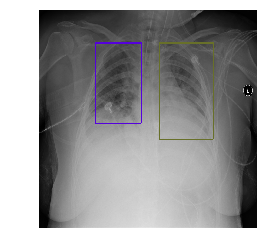

In [12]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

## Exploring Detailed Labels

In this challenge, the primary endpoint will be the detection of bounding boxes consisting of a binary classification---e.g. the presence or absence of pneumonia. However, in addition to the binary classification, each bounding box *without* pneumonia is further categorized into *normal* or *no lung opacity / not normal*. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image---and oftentimes this finding may mimic the appearance of true pneumonia. Keep in mind that this extra class is provided as supplemental information to help improve algorithm accuracy if needed; generation of this separate class **will not** be a formal metric used to evaluate performance in this competition.

As above, we saw that the first patient in the CSV file did not have pneumonia. Let's look at the detailed label information for this patient:

In [13]:
df_detailed = pd.read_csv('./data/stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


As we see here, the patient does not have pneumonia however *does* have another imaging abnormality present. Let's take a closer look:

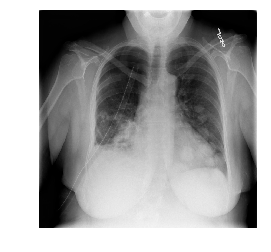

In [14]:
patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

While the image displayed inline within the notebook is small, as a radiologist it is evident that the patient has several well circumscribed nodular densities in the left lung (right side of image). In addition there is a large chest tube in the right lung (left side of the image) which has been placed to drain fluid accumulation (e.g. pleural effusion) at the right lung base that also demonstrates overlying patchy densities (e.g. possibly atelectasis or partial lung collapse).

As you can see, there are a number of abnormalities on the image, and the determination that none of these findings correlate to pneumonia is somewhat subjective even among expert physicians. Therefore, as is almost always the case in medical imaging datasets, the provided ground-truth labels are far from 100% objective. Keep this in mind as you develop your algorithm, and consider consultation with a radiologist physician to help determine an optimal strategy for mitigating these discrepencies.

## Label Summary

Finally, let us take a closer look at the distribution of labels in the dataset. To do so we will first parse the detailed label information:

In [15]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
display(summary)

{'No Lung Opacity / Not Normal': 11500, 'Normal': 8525, 'Lung Opacity': 8964}

In [16]:
type(df_detailed)

pandas.core.frame.DataFrame

In [17]:
df_detailed['class'].value_counts()

No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64

As we can see, there is a relatively even split between the three classes, with nearly 2/3rd of the data comprising of no pneumonia (either completely *normal* or *no lung opacity / not normal*). Compared to most medical imaging datasets, where the prevalence of disease is quite low, this dataset has been significantly enriched with pathology.

# Next Steps

Now that you understand the data structures, imaging file formats and label types, it's time to make an algorithm! Keep in mind that the primary endpoint is the detection of bounding boxes, thus you will likely be considering various **object localization** algorithms. An alternative strategy is to consider the related family of **segmentation** algorithms with the acknowledgement that bounding boxes will only be a coarse approximation to true pixel-by-pixel image segmentation masks.

Finally, as alluded to several times in this notebook, a radiologist physican may often times provide useful ancillary information, strategy for algorithm development and/or additional label reconciliation. In addition to physicians you may have access to locally, the RSNA will reach out to radiologists and facilitate engagement remotely through the Kaggle online forums. As a medical professional, I know that many of my colleagues are very interested in getting started so please feel free to reach out and start a conversation! 

Good luck!

<span style='color:green'>Tom's Notes</span>

So what exactly am I trying to do here. I'm trying to detect pneumonia in an xray-type scan given to me as dicom files. 

Primarily there are two outputs (of a sort):
- Classification (normal, abnormal, pneumonia)
    - In these examples, normal and abnormal can be combined into 1 category such that there is binary yes/no for pneumonia. This may or may not be useful.
- Bounding box(es) for areas that contain the pneumonia

How am I planning on accomplishing theses tasks?
- We have just started learning about neural networks. As such, I can envision a classification NN that tells me whether or not there is pneumonia. Getting it to actually give me the coordinates, in some cases multiple coordinates, is a bit more difficult of a venture for me to see at the moment

What I've done:
- Read through the starter section of the kaggle competition
- Gone through this notebook, understanding how to view the dicom pics and relate them to their patient files and other meta data. 

Next steps:
- begin going through the forum for this competition
- I believe there is more material to reference before I go completely off on my own
- figure out exactly how the bounding boxes are measured
- look into 'object localization' and 'segmentation' algorithms

There is a ipynb that is much more in depth and seems to give a pretty in-depth code example at first glance. 

In [18]:
64**2

4096